# Parallelization Demo

### Usecase: Generate a Story
* `Start`
* `Node 1` will generate different Characters 
* `Node 2` will generate a story premise
* `Node 3` will generate the setting of the story
* `Node 4` will then all these components and generate a story
* `End`

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

from langchain_groq import ChatGroq
llm = ChatGroq(model="gemma2-9b-it")

In [8]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image
from langchain_core.messages import HumanMessage, SystemMessage

# graph state
class State(TypedDict):
    topic: str
    characters: str
    premise: str
    setting: str
    story: str

# creating nodes
def generate_characters(state: State):
    """Generate character descriptions"""
    prompt = [
        SystemMessage(content=f"You are an expert character writer."),
        HumanMessage(content=f"Create two character names and brief traits for a story about {state["topic"]}")
    ]
    msg = llm.invoke(prompt)
    return {"characters":msg.content}

def generate_premise(state: State):
    """Generate a premise for story"""
    prompt = [
        SystemMessage(content=f"You are a helpful Literature assistant."),
        HumanMessage(content=f"Write a one sentence plot premise for a story about {state["topic"]}")
    ]
    msg = llm.invoke(prompt)
    return {"premise":msg.content}

def generate_setting(state: State):
    """Generate a story setting"""
    prompt = [
        SystemMessage(content=f"You are a helpful Story teller."),
        HumanMessage(content=f"Describe a vivid setting for a story about {state["topic"]}")
    ]
    msg = llm.invoke(prompt)
    return {"setting":msg.content}

def generate_story(state: State):
    """Generate final story"""
    prompt = [
        SystemMessage(content=f"You are an expert Story writer."),
        HumanMessage(content=f"""
                    Write a short story introduction using these elements:
                    Topic: {state["topic"]}
                    Characters: {state["characters"]}
                    Premise: {state["premise"]}
                    Setting: {state["setting"]}
                    """)
    ]
    msg = llm.invoke(prompt)
    return {"story":msg.content}

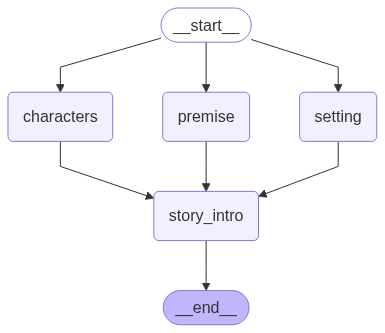

In [9]:
# build the graph
graph = StateGraph(State)
graph.add_node("characters", generate_characters)
graph.add_node("premise", generate_premise)
graph.add_node("setting", generate_setting)
graph.add_node("story_intro", generate_story)

# define the edges
graph.add_edge(START, "characters")
graph.add_edge(START, "premise")
graph.add_edge(START, "setting")

graph.add_edge("characters", "story_intro")
graph.add_edge("premise", "story_intro")
graph.add_edge("setting", "story_intro")
graph.add_edge("story_intro", END)

# compile the graph
compiled_graph = graph.compile()

# display the graph
display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [10]:
# Run the graph
state = {"topic":"Indian Romantic Comedy"}
result = compiled_graph.invoke(state)
result

{'topic': 'Indian Romantic Comedy',
 'characters': "Here are two character names and brief traits for an Indian Romantic Comedy:\n\n**1. Name:** Maya Kapoor\n\n* **Traits:**  Bubbly, optimistic, and fiercely independent. Maya is a talented photographer who dreams of opening her own studio. She's a bit of a free spirit who doesn't let societal expectations box her in, much to the chagrin of her traditional family.  \n\n**2. Name:** Rohan Sharma\n\n* **Traits:**  Charming, witty, and slightly cynical. Rohan is a successful architect who seems to have it all but secretly yearns for something more meaningful. He's a bit of a playboy, but beneath his casual demeanor lies a kind heart. \n\n\nLet me know if you'd like me to flesh out these characters further or create some more! \n",
 'premise': "When a free-spirited young woman clashes with a traditional young man during a lavish wedding, their forced proximity sparks an unlikely and hilarious romance. \n\n\nLet me know if you'd like me to d

In [11]:
print(result["story"])

The setting sun cast long, dramatic shadows across the sprawling courtyard of the opulent Maharaja Palace. Marigold petals rained from the elaborately decorated balconies, each landing with a soft 'thud' on the manicured lawns below.  It was a scene straight out of a Bollywood movie,  and Maya Kapoor, camera poised and ready, was determined to capture its magic.  She was there to document the wedding of the century, a whirlwind of silks, jewels, and barely contained excitement. But Maya, with her bright pink kurti clashing against the traditional hues, felt a bit like a peacock amongst peacocks.

 Across the courtyard, Rohan Sharma, impeccably dressed in a sherwani that seemed to shimmer under the fading light, surveyed the scene with a world-weary sigh. He was the architect of this extravagant affair, hired by the Maharaja himself to transform his ancestral home into a fairytale setting. The success of the wedding, however, was beginning to feel more like a gilded cage than a celebrat